In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, residual_num=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels//2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels//2, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.residual = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1, stride=1, padding=0)
        )
        self.residual_num = residual_num

    def forward(self, x):
        out = self.conv2(self.conv1(x))
        for i in range(self.residual_num):
            out = out + self.residual(out)

        return out


In [5]:
class Decoder(nn.Module):
    def __init__(self, hidden_channels, out_channels, residual_num=2):
        super().__init__()
        self.conv_trans_1 = nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=hidden_channels//2, kernel_size=4, stride=2, padding=1)
        self.conv_trans_2 = nn.ConvTranspose2d(in_channels=hidden_channels//2, out_channels=out_channels, kernel_size=4, stride=2, padding=1)
        self.residual = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1, stride=1, padding=0)
        )
        self.residual_num = residual_num

    def forward(self, x):
        out = x
        for i in range(self.residual_num):
            out = out + self.residual(out)
        out = self.conv_trans_2(self.conv_trans_1(out))
        return out

In [6]:
class CodeBook(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1./num_embeddings, 1./num_embeddings)

    def forward(self, x):
        N, D, H, W = x.shape
        x = x.permute(0, 2, 3, 1)
        x = torch.flatten(x, end_dim=2)

        dist = torch.cdist(x, self.embedding.weight[None, :]).squeeze()
        min_indices = torch.argmin(dist, dim=1)
        out = self.embedding.weight[min_indices]
        commitment_loss = F.mse_loss(out.detach(), x, reduction='mean')
        codebook_loss = F.mse_loss(out, x.detach(), reduction='mean')
        out = x + (out - x).detach()
        out = out.reshape(N, H, W, D).permute(0, 3, 1, 2)
        return out, commitment_loss, codebook_loss


In [7]:
class VQ_VAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_embeddings, embedding_dim, residual_num=2):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_channels, residual_num=residual_num)
        self.decoder = Decoder( hidden_channels, in_channels, residual_num=residual_num)
        self.code_book = CodeBook(num_embeddings, embedding_dim)
        self.pre_embedding_conv = nn.Conv2d(hidden_channels, embedding_dim, kernel_size=1, stride=1, padding=0)
        self.pre_dec_conv = nn.Conv2d(embedding_dim, hidden_channels, kernel_size=1, stride=1, padding=0)
        self.recon_loss = 0
        self.commitment_loss, self.codebook_loss = 0, 0

    def forward(self, x):
        out = self.encoder(x)
        z, self.commitment_loss, self.codebook_loss = self.code_book(self.pre_embedding_conv(out))
        out = self.decoder(self.pre_dec_conv(z))
        self.recon_loss = F.mse_loss(out, x, reduction='mean')
        #print(f'recon loss = {self.recon_loss}')
        return out, z

    def compute_loss(self, beta=0.2):
        return self.recon_loss + self.codebook_loss + (beta * self.commitment_loss)




In [8]:
def train_model(model, train_loader, optimizer, num_epochs=10, device=device):
    z_anim_list = []
    num_samples = 3
    torch.manual_seed(42)

    total_loss_list = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0.

        for batch_idx, (data, _) in enumerate(iter(train_loader)):
            data = data.to(device)
            out, z = model(data)
            loss = model.compute_loss()
            total_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (batch_idx % 10 == 0):
                z_anim_list.append(z[z.shape[0]-1])
        if (epoch+1) % 5 == 0:
            fig, axs = plt.subplots(num_samples, 3, figsize=(7, 6))

            for i in range(num_samples):
                axs[i][0].imshow(data[i].squeeze().cpu(), cmap='gray')
                axs[i][1].imshow(out[i].squeeze().detach().cpu(), cmap='gray')
                axs[i][2].scatter(z[i][0].detach().cpu(), z[i][1].detach().cpu())
                axs[i][0].axis('off')
                axs[i][1].axis('off')
            plt.show()
        total_loss_list.append(total_loss)
    return model, total_loss_list, z_anim_list


In [9]:
vq_vae_model = VQ_VAE(1, 250, 3, 2).to(device)
optimizer = optim.Adam(vq_vae_model.parameters(), lr=0.0001)

 10%|█         | 4/40 [01:28<13:14, 22.07s/it]

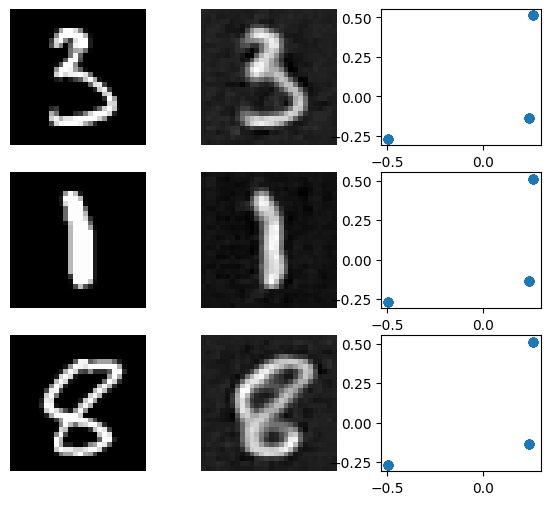

 22%|██▎       | 9/40 [03:23<11:49, 22.88s/it]

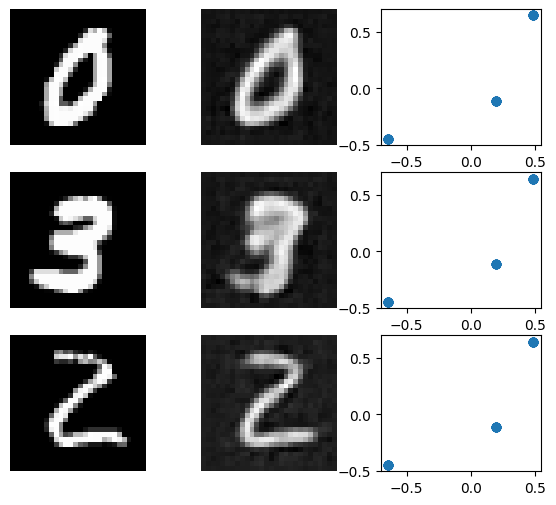

 35%|███▌      | 14/40 [05:18<09:56, 22.96s/it]

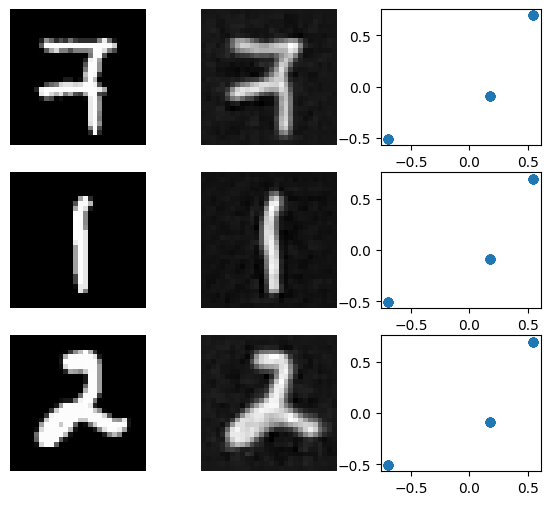

 48%|████▊     | 19/40 [07:13<08:03, 23.04s/it]

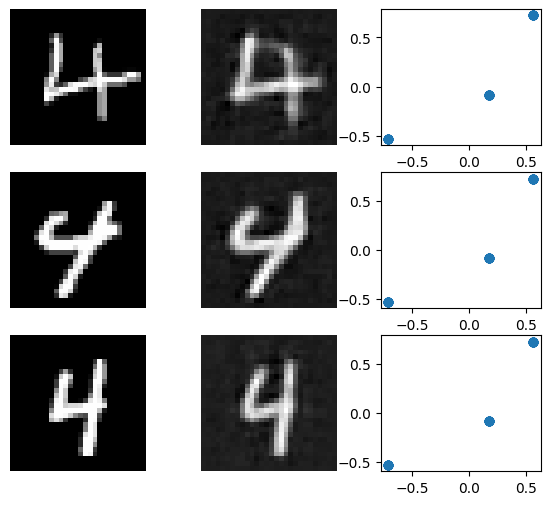

 60%|██████    | 24/40 [09:09<06:07, 22.98s/it]

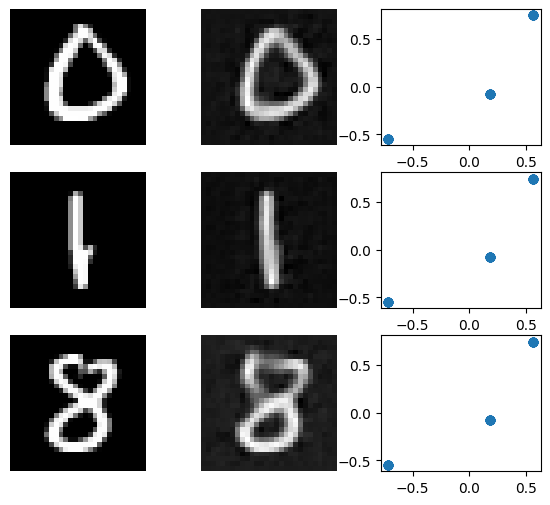

 72%|███████▎  | 29/40 [11:04<04:13, 23.03s/it]

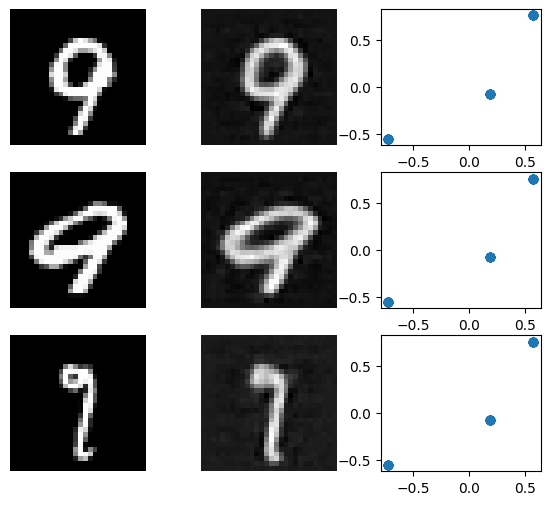

 85%|████████▌ | 34/40 [12:59<02:18, 23.03s/it]

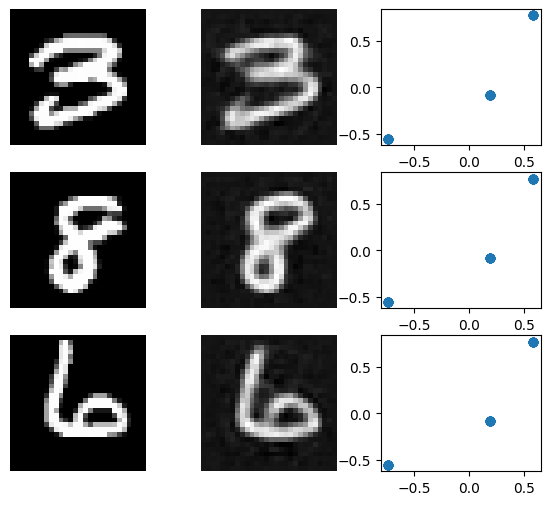

 98%|█████████▊| 39/40 [14:55<00:23, 23.02s/it]

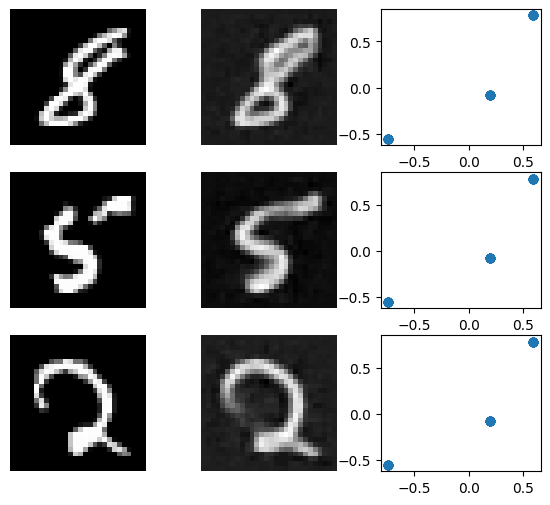

100%|██████████| 40/40 [15:18<00:00, 22.97s/it]


In [10]:
total_loss_list = []
vq_vae_model ,total_loss_list, z_anim_list = train_model(vq_vae_model, train_loader, optimizer, num_epochs=40)

**همانگونه که از شکل های بالا مشخص است سه بردار موجود در کدبوک به سمت یک خط همگرا می گردند**

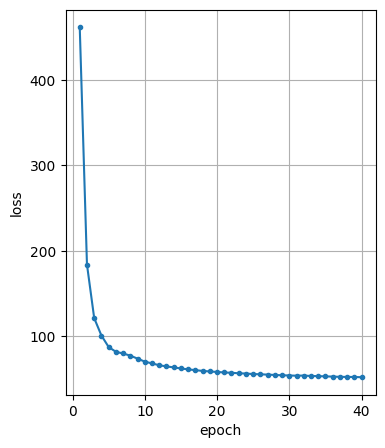

In [11]:
total_loss = torch.tensor(total_loss_list, device='cpu')
epoch = np.arange(1, 41)
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
ax.plot(epoch, total_loss, '.-')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid(True)
plt.show()

<ipython-input-12-d9a9523c027e>:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  points = z_anim_list[frame].T.detach().cpu().numpy()


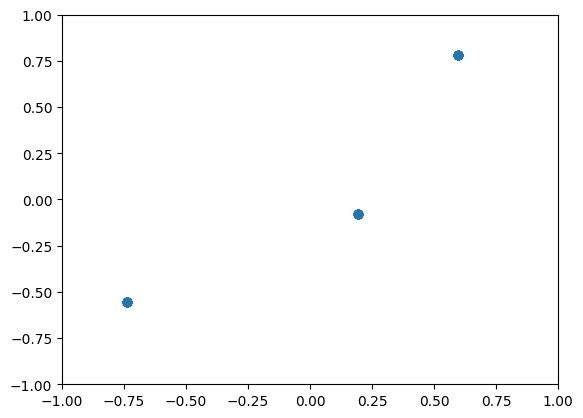

In [12]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots()
scatter = ax.scatter([], [])
ax.set_xlim(-1, 1)  # Adjust the x-axis limits as needed
ax.set_ylim(-1, 1)  # Adjust the y-axis limits as needed

def update(frame):

    # Extract 3x3 points for the current instance in the batch
    points = z_anim_list[frame].T.detach().cpu().numpy()
    points = points.reshape(-1, 2)
    # Update scatter plot
    scatter.set_offsets(points)

    return scatter,

# Create the animation
animation = FuncAnimation(fig, update, frames=range(len(z_anim_list)), interval=200, blit=True)

# Save the animation as a GIF
writer = PillowWriter(fps=60)
animation.save('animation.gif', writer=writer)

# Display the animation (optional)
plt.show()


In [20]:
# this function convert grayscale image to color image
def convert_to_color(image):
    multipliers = torch.rand(3)
    multipliers = multipliers.view(3, 1, 1)
    colored_image = image * multipliers

    return colored_image


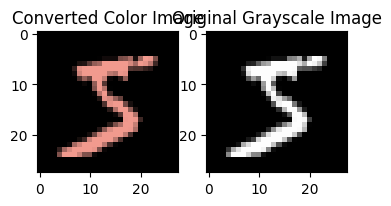

In [21]:
# create colorful dataset
colored_images = []
labels = []

for image, label in train_dataset:
    colored_image = convert_to_color(image)
    colored_images.append(colored_image)
    labels.append(label)

colored_images = torch.stack(colored_images)
labels = torch.tensor(labels)

colored_train_dataset = TensorDataset(colored_images, labels)

sample_index = 0
sample_image, sample_label = colored_train_dataset[sample_index]

# Display the original and colored images
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.permute(1, 2, 0).numpy())
plt.title('Converted Color Image')
plt.subplot(1, 2, 2)
plt.imshow(train_dataset[sample_index][0].squeeze().numpy(), cmap='gray')
plt.title('Original Grayscale Image')
plt.show()


In [ ]:
train_loader2 = DataLoader(colored_train_dataset, batch_size=64, shuffle=True)


In [ ]:
def train_model_2(model, train_loader, optimizer, num_epochs=20, device=device):
    num_samples = 3
    torch.manual_seed(42)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0.

        for data, _ in iter(train_loader):
            data = data.to(device)
            out, _ = model(data)

            loss = model.compute_loss()
            total_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 5 == 0:
            fig, axs = plt.subplots(num_samples, 2, figsize=(6, 6))
            for i in range(num_samples):
                axs[i][0].imshow(data[i].permute(1, 2, 0).cpu())
                axs[i][1].imshow(out[i].permute(1, 2, 0).detach().cpu())
                axs[i][0].axis('off')
                axs[i][1].axis('off')
            plt.show()
        print(f'epoch{epoch+1} : loss={total_loss}')
        print('-'*40)
    return model


In [ ]:
import gc
if device == 'cuda':
    torch.cuda.empty_cache()
    gc.collect()

#train original model with 3 2-d vectors

  3%|▎         | 1/30 [00:11<05:47, 11.98s/it]

epoch1 : loss=96.4101333618164
----------------------------------------


  7%|▋         | 2/30 [00:23<05:33, 11.92s/it]

epoch2 : loss=64.44248962402344
----------------------------------------


 10%|█         | 3/30 [00:35<05:19, 11.82s/it]

epoch3 : loss=56.972869873046875
----------------------------------------


 13%|█▎        | 4/30 [00:47<05:05, 11.76s/it]

epoch4 : loss=51.316349029541016
----------------------------------------


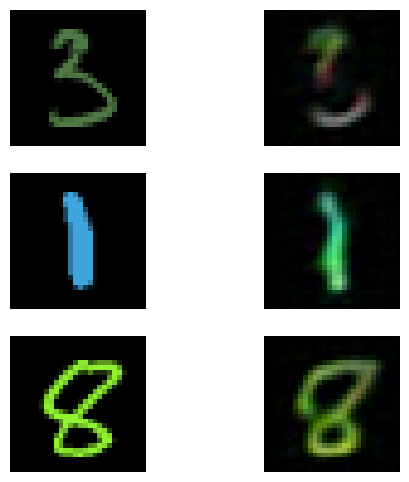

 17%|█▋        | 5/30 [00:59<04:55, 11.81s/it]

epoch5 : loss=48.39070129394531
----------------------------------------


 20%|██        | 6/30 [01:10<04:42, 11.75s/it]

epoch6 : loss=46.261497497558594
----------------------------------------


 23%|██▎       | 7/30 [01:22<04:29, 11.70s/it]

epoch7 : loss=45.07355880737305
----------------------------------------


 27%|██▋       | 8/30 [01:33<04:15, 11.63s/it]

epoch8 : loss=44.54437255859375
----------------------------------------


 30%|███       | 9/30 [01:45<04:03, 11.58s/it]

epoch9 : loss=43.8010368347168
----------------------------------------


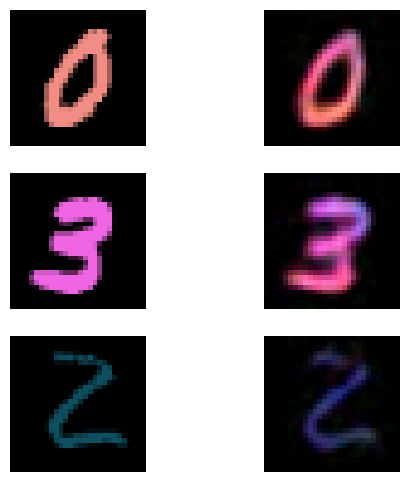

 33%|███▎      | 10/30 [01:56<03:52, 11.60s/it]

epoch10 : loss=43.67283630371094
----------------------------------------


 37%|███▋      | 11/30 [02:08<03:39, 11.58s/it]

epoch11 : loss=43.09788513183594
----------------------------------------


 40%|████      | 12/30 [02:20<03:28, 11.57s/it]

epoch12 : loss=42.68675231933594
----------------------------------------


 43%|████▎     | 13/30 [02:31<03:17, 11.60s/it]

epoch13 : loss=42.094268798828125
----------------------------------------


 47%|████▋     | 14/30 [02:43<03:05, 11.59s/it]

epoch14 : loss=41.512569427490234
----------------------------------------


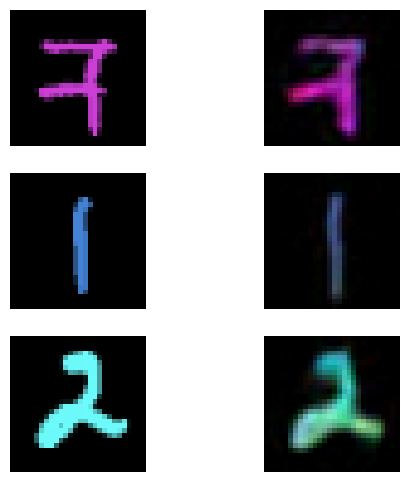

 50%|█████     | 15/30 [02:55<02:54, 11.65s/it]

epoch15 : loss=41.031898498535156
----------------------------------------


 53%|█████▎    | 16/30 [03:06<02:42, 11.64s/it]

epoch16 : loss=40.504150390625
----------------------------------------


 57%|█████▋    | 17/30 [03:18<02:31, 11.62s/it]

epoch17 : loss=40.206886291503906
----------------------------------------


 60%|██████    | 18/30 [03:29<02:19, 11.61s/it]

epoch18 : loss=39.54789352416992
----------------------------------------


 63%|██████▎   | 19/30 [03:41<02:07, 11.60s/it]

epoch19 : loss=39.294639587402344
----------------------------------------


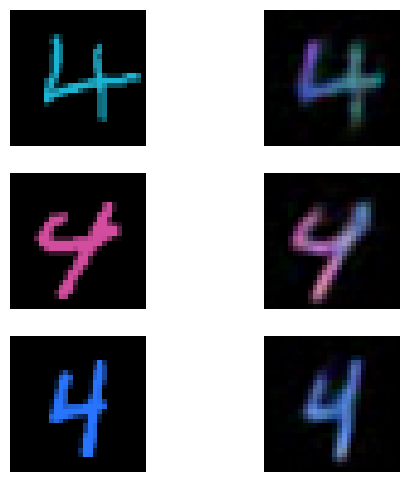

 67%|██████▋   | 20/30 [03:53<01:56, 11.64s/it]

epoch20 : loss=38.848270416259766
----------------------------------------


 70%|███████   | 21/30 [04:04<01:44, 11.61s/it]

epoch21 : loss=38.68970489501953
----------------------------------------


 73%|███████▎  | 22/30 [04:16<01:32, 11.57s/it]

epoch22 : loss=38.39261245727539
----------------------------------------


 77%|███████▋  | 23/30 [04:27<01:20, 11.56s/it]

epoch23 : loss=38.057151794433594
----------------------------------------


 80%|████████  | 24/30 [04:39<01:09, 11.56s/it]

epoch24 : loss=37.742713928222656
----------------------------------------


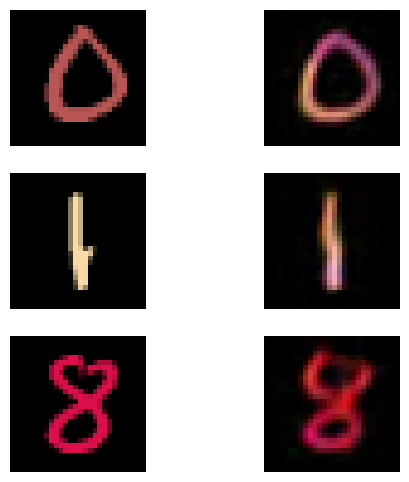

 83%|████████▎ | 25/30 [04:51<00:58, 11.80s/it]

epoch25 : loss=37.58047866821289
----------------------------------------


 87%|████████▋ | 26/30 [05:03<00:46, 11.75s/it]

epoch26 : loss=37.39669418334961
----------------------------------------


 90%|█████████ | 27/30 [05:14<00:35, 11.71s/it]

epoch27 : loss=37.169677734375
----------------------------------------


 93%|█████████▎| 28/30 [05:26<00:23, 11.66s/it]

epoch28 : loss=36.93277359008789
----------------------------------------


 97%|█████████▋| 29/30 [05:38<00:11, 11.64s/it]

epoch29 : loss=36.831356048583984
----------------------------------------


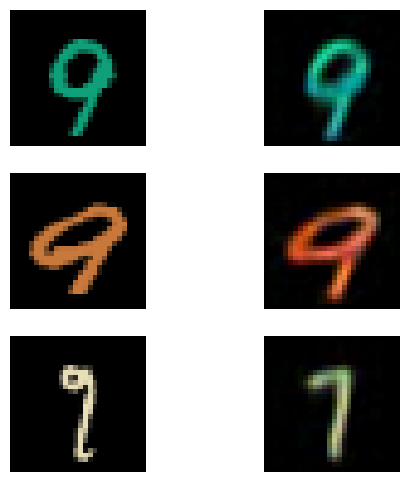

100%|██████████| 30/30 [05:49<00:00, 11.66s/it]

epoch30 : loss=36.571998596191406
----------------------------------------


In [ ]:
vq_vae_model1 = VQ_VAE(3, 200, 3, 2).to(device)
optimizer = optim.Adam(vq_vae_model1.parameters(), lr=0.0001)
vq_vae_model1 = train_model_2(vq_vae_model1, train_loader2, optimizer, num_epochs=30)

**همانگونه که ملاحظه می شود با همان مدل قبل یعنی سه بردار دو بعدی شبکه در تشخیص عدد و ساخت دوباره آن خوب عمل می کند اما نمی تواند رنگ عدد مربوطه را بازتولید کند**

#increasing number of vectors

  3%|▎         | 1/30 [00:10<05:04, 10.48s/it]

epoch1 : loss=142.60009765625
----------------------------------------


  7%|▋         | 2/30 [00:20<04:51, 10.42s/it]

epoch2 : loss=51.21183776855469
----------------------------------------


 10%|█         | 3/30 [00:31<04:39, 10.36s/it]

epoch3 : loss=24.56015396118164
----------------------------------------


 13%|█▎        | 4/30 [00:41<04:28, 10.33s/it]

epoch4 : loss=14.664167404174805
----------------------------------------


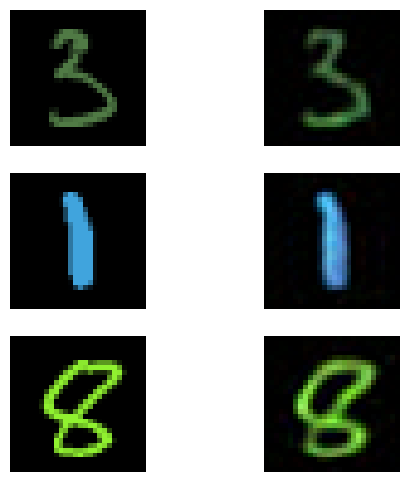

 17%|█▋        | 5/30 [00:51<04:19, 10.40s/it]

epoch5 : loss=11.700185775756836
----------------------------------------


 20%|██        | 6/30 [01:02<04:08, 10.37s/it]

epoch6 : loss=10.456586837768555
----------------------------------------


 23%|██▎       | 7/30 [01:12<03:58, 10.35s/it]

epoch7 : loss=9.9766263961792
----------------------------------------


 27%|██▋       | 8/30 [01:22<03:47, 10.34s/it]

epoch8 : loss=9.722762107849121
----------------------------------------


 30%|███       | 9/30 [01:33<03:37, 10.34s/it]

epoch9 : loss=9.585163116455078
----------------------------------------


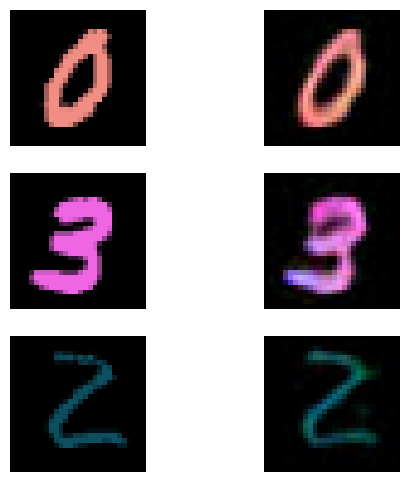

 33%|███▎      | 10/30 [01:43<03:28, 10.40s/it]

epoch10 : loss=9.57204818725586
----------------------------------------


 37%|███▋      | 11/30 [01:54<03:17, 10.39s/it]

epoch11 : loss=9.619327545166016
----------------------------------------


 40%|████      | 12/30 [02:04<03:06, 10.36s/it]

epoch12 : loss=9.659414291381836
----------------------------------------


 43%|████▎     | 13/30 [02:14<02:55, 10.35s/it]

epoch13 : loss=9.649009704589844
----------------------------------------


 47%|████▋     | 14/30 [02:25<02:45, 10.35s/it]

epoch14 : loss=9.642865180969238
----------------------------------------


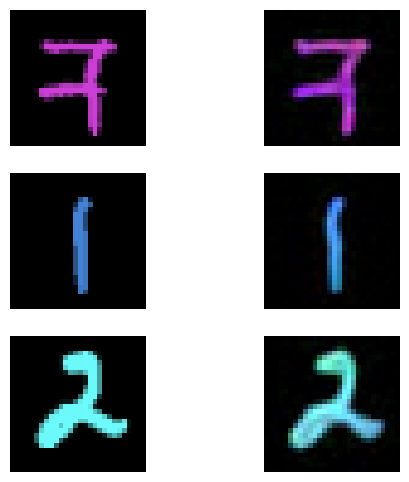

 50%|█████     | 15/30 [02:35<02:36, 10.42s/it]

epoch15 : loss=9.604646682739258
----------------------------------------


 53%|█████▎    | 16/30 [02:46<02:25, 10.42s/it]

epoch16 : loss=9.553949356079102
----------------------------------------


 57%|█████▋    | 17/30 [02:56<02:15, 10.40s/it]

epoch17 : loss=9.518019676208496
----------------------------------------


 60%|██████    | 18/30 [03:06<02:04, 10.39s/it]

epoch18 : loss=9.454385757446289
----------------------------------------


 63%|██████▎   | 19/30 [03:17<01:54, 10.38s/it]

epoch19 : loss=9.379328727722168
----------------------------------------


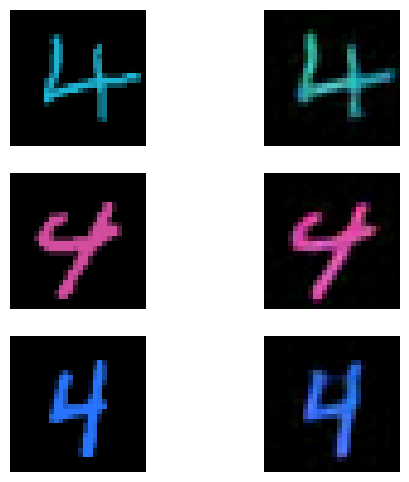

 67%|██████▋   | 20/30 [03:27<01:44, 10.43s/it]

epoch20 : loss=9.305034637451172
----------------------------------------


 70%|███████   | 21/30 [03:38<01:33, 10.41s/it]

epoch21 : loss=9.239916801452637
----------------------------------------


 73%|███████▎  | 22/30 [03:48<01:23, 10.38s/it]

epoch22 : loss=9.202803611755371
----------------------------------------


 77%|███████▋  | 23/30 [03:58<01:12, 10.37s/it]

epoch23 : loss=9.15895938873291
----------------------------------------


 80%|████████  | 24/30 [04:09<01:02, 10.35s/it]

epoch24 : loss=9.122991561889648
----------------------------------------


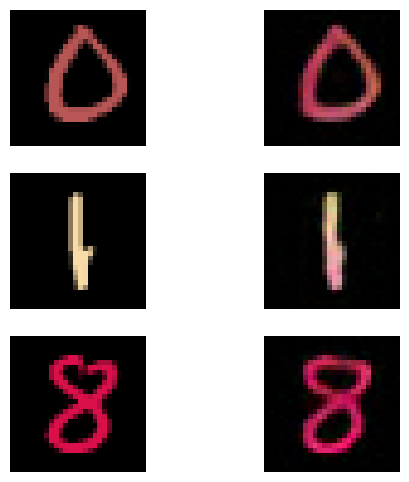

 83%|████████▎ | 25/30 [04:19<00:52, 10.41s/it]

epoch25 : loss=9.090399742126465
----------------------------------------


 87%|████████▋ | 26/30 [04:29<00:41, 10.39s/it]

epoch26 : loss=9.054069519042969
----------------------------------------


 90%|█████████ | 27/30 [04:40<00:31, 10.35s/it]

epoch27 : loss=9.028013229370117
----------------------------------------


 93%|█████████▎| 28/30 [04:50<00:20, 10.34s/it]

epoch28 : loss=8.990673065185547
----------------------------------------


 97%|█████████▋| 29/30 [05:00<00:10, 10.32s/it]

epoch29 : loss=8.960616111755371
----------------------------------------


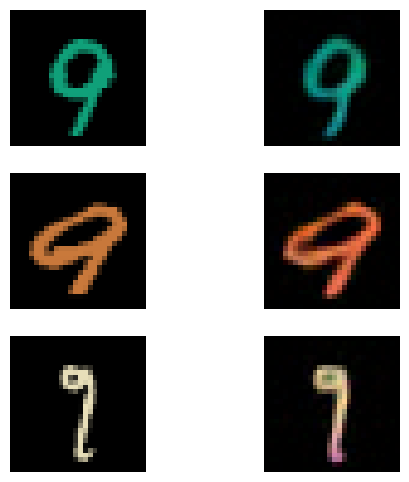

100%|██████████| 30/30 [05:11<00:00, 10.38s/it]

epoch30 : loss=8.916518211364746
----------------------------------------


In [ ]:
vq_vae_model1 = VQ_VAE(3, 200, 20, 2).to(device)
optimizer = optim.Adam(vq_vae_model1.parameters(), lr=0.0001)
vq_vae_model1 = train_model_2(vq_vae_model1, train_loader2, optimizer, num_epochs=30)

  3%|▎         | 1/30 [00:10<05:02, 10.42s/it]

epoch1 : loss=140.3666534423828
----------------------------------------


  7%|▋         | 2/30 [00:20<04:47, 10.28s/it]

epoch2 : loss=32.467613220214844
----------------------------------------


 10%|█         | 3/30 [00:30<04:34, 10.18s/it]

epoch3 : loss=12.223657608032227
----------------------------------------


 13%|█▎        | 4/30 [00:40<04:23, 10.14s/it]

epoch4 : loss=8.202676773071289
----------------------------------------


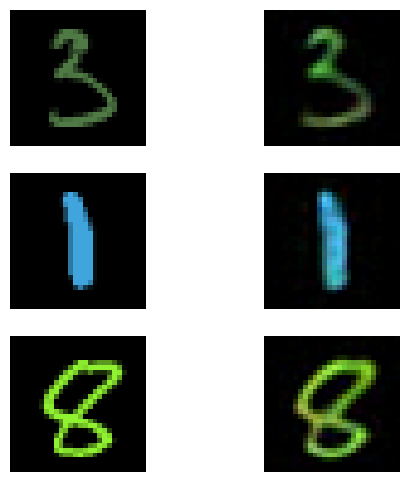

 17%|█▋        | 5/30 [00:51<04:15, 10.21s/it]

epoch5 : loss=6.741052150726318
----------------------------------------


 20%|██        | 6/30 [01:01<04:03, 10.16s/it]

epoch6 : loss=6.053919792175293
----------------------------------------


 23%|██▎       | 7/30 [01:11<03:52, 10.11s/it]

epoch7 : loss=5.694875240325928
----------------------------------------


 27%|██▋       | 8/30 [01:21<03:42, 10.09s/it]

epoch8 : loss=5.501897811889648
----------------------------------------


 30%|███       | 9/30 [01:31<03:31, 10.08s/it]

epoch9 : loss=5.382246494293213
----------------------------------------


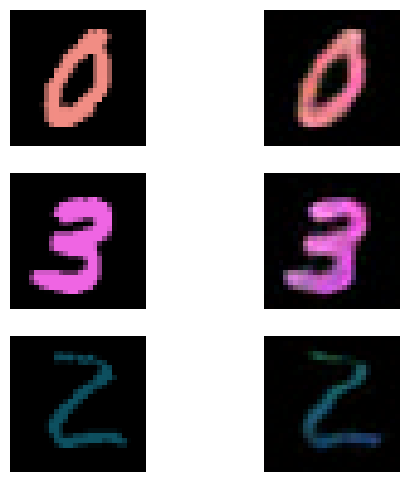

 33%|███▎      | 10/30 [01:41<03:22, 10.13s/it]

epoch10 : loss=5.318472862243652
----------------------------------------


 37%|███▋      | 11/30 [01:51<03:12, 10.12s/it]

epoch11 : loss=5.301511764526367
----------------------------------------


 40%|████      | 12/30 [02:01<03:01, 10.10s/it]

epoch12 : loss=5.296078205108643
----------------------------------------


 43%|████▎     | 13/30 [02:11<02:51, 10.07s/it]

epoch13 : loss=5.306369304656982
----------------------------------------


 47%|████▋     | 14/30 [02:21<02:40, 10.05s/it]

epoch14 : loss=5.31322717666626
----------------------------------------


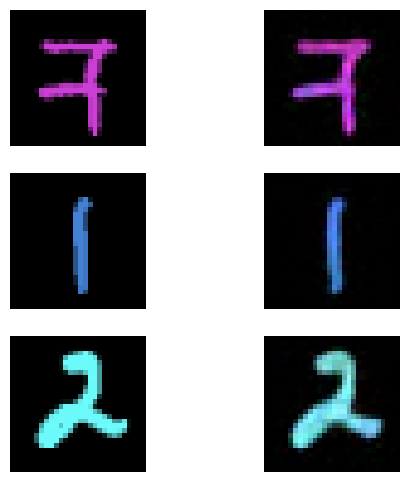

 50%|█████     | 15/30 [02:31<02:31, 10.11s/it]

epoch15 : loss=5.313154220581055
----------------------------------------


 53%|█████▎    | 16/30 [02:41<02:21, 10.09s/it]

epoch16 : loss=5.318471908569336
----------------------------------------


 57%|█████▋    | 17/30 [02:51<02:10, 10.07s/it]

epoch17 : loss=5.304145336151123
----------------------------------------


 60%|██████    | 18/30 [03:02<02:00, 10.08s/it]

epoch18 : loss=5.299129009246826
----------------------------------------


 63%|██████▎   | 19/30 [03:12<01:50, 10.07s/it]

epoch19 : loss=5.281676769256592
----------------------------------------


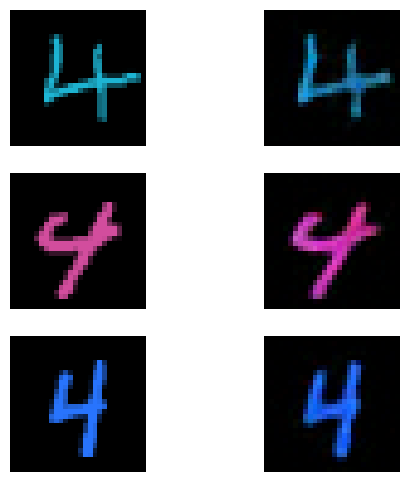

 67%|██████▋   | 20/30 [03:22<01:41, 10.13s/it]

epoch20 : loss=5.262164115905762
----------------------------------------


 70%|███████   | 21/30 [03:32<01:31, 10.11s/it]

epoch21 : loss=5.249611854553223
----------------------------------------


 73%|███████▎  | 22/30 [03:42<01:20, 10.09s/it]

epoch22 : loss=5.221970081329346
----------------------------------------


 77%|███████▋  | 23/30 [03:52<01:10, 10.07s/it]

epoch23 : loss=5.209158897399902
----------------------------------------


 80%|████████  | 24/30 [04:02<01:00, 10.09s/it]

epoch24 : loss=5.185902118682861
----------------------------------------


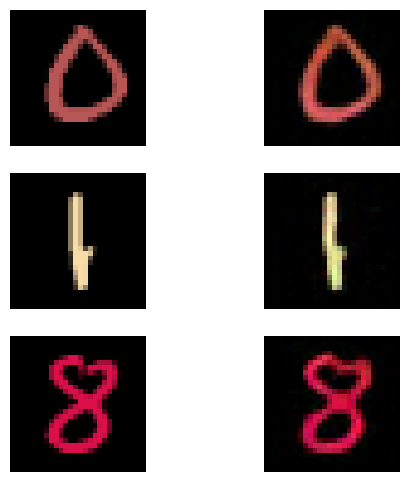

 83%|████████▎ | 25/30 [04:12<00:50, 10.15s/it]

epoch25 : loss=5.1703081130981445
----------------------------------------


 87%|████████▋ | 26/30 [04:22<00:40, 10.11s/it]

epoch26 : loss=5.142175197601318
----------------------------------------


 90%|█████████ | 27/30 [04:33<00:30, 10.10s/it]

epoch27 : loss=5.126936912536621
----------------------------------------


 93%|█████████▎| 28/30 [04:43<00:20, 10.07s/it]

epoch28 : loss=5.106827735900879
----------------------------------------


 97%|█████████▋| 29/30 [04:53<00:10, 10.07s/it]

epoch29 : loss=5.079612731933594
----------------------------------------


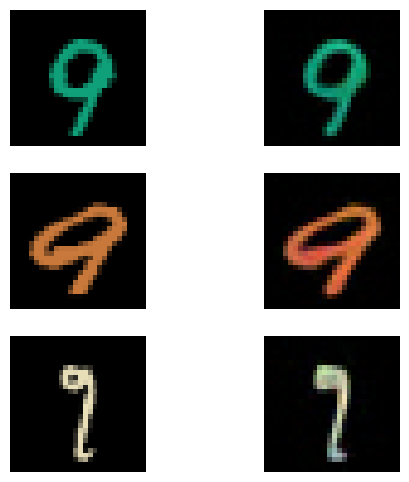

100%|██████████| 30/30 [05:03<00:00, 10.11s/it]

epoch30 : loss=5.077930927276611
----------------------------------------


In [ ]:
vq_vae_model1 = VQ_VAE(3, 200, 50, 2).to(device)
optimizer = optim.Adam(vq_vae_model1.parameters(), lr=0.0001)
vq_vae_model1 = train_model_2(vq_vae_model1, train_loader2, optimizer, num_epochs=30)

**با زیاد کردن تعداد بردار ها خود رمزگذار مربوطه قادر به بازتولید رنگ نیز می باشد**

#increasing dimensions of vectors

  3%|▎         | 1/30 [00:11<05:46, 11.95s/it]

epoch1 : loss=81.49105072021484
----------------------------------------


  7%|▋         | 2/30 [00:23<05:32, 11.86s/it]

epoch2 : loss=115.70124816894531
----------------------------------------


 10%|█         | 3/30 [00:35<05:18, 11.81s/it]

epoch3 : loss=109.01469421386719
----------------------------------------


 13%|█▎        | 4/30 [00:47<05:06, 11.79s/it]

epoch4 : loss=102.19734954833984
----------------------------------------


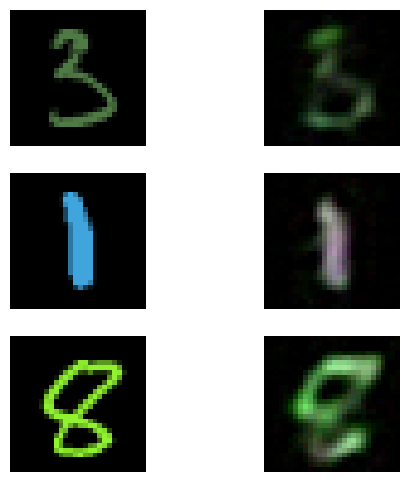

 17%|█▋        | 5/30 [00:59<05:00, 12.00s/it]

epoch5 : loss=98.18561553955078
----------------------------------------


 20%|██        | 6/30 [01:11<04:45, 11.88s/it]

epoch6 : loss=96.70952606201172
----------------------------------------


 23%|██▎       | 7/30 [01:22<04:31, 11.79s/it]

epoch7 : loss=99.13031768798828
----------------------------------------


 27%|██▋       | 8/30 [01:34<04:17, 11.71s/it]

epoch8 : loss=103.37862396240234
----------------------------------------


 30%|███       | 9/30 [01:46<04:05, 11.67s/it]

epoch9 : loss=102.6019058227539
----------------------------------------


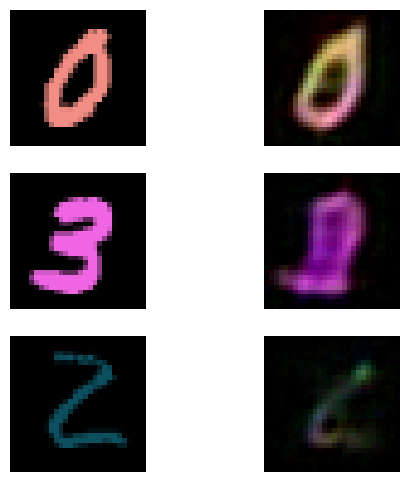

 33%|███▎      | 10/30 [01:57<03:54, 11.71s/it]

epoch10 : loss=100.467529296875
----------------------------------------


 37%|███▋      | 11/30 [02:09<03:41, 11.66s/it]

epoch11 : loss=97.89949035644531
----------------------------------------


 40%|████      | 12/30 [02:20<03:29, 11.63s/it]

epoch12 : loss=96.0173110961914
----------------------------------------


 43%|████▎     | 13/30 [02:32<03:17, 11.59s/it]

epoch13 : loss=94.63237762451172
----------------------------------------


 47%|████▋     | 14/30 [02:43<03:05, 11.58s/it]

epoch14 : loss=93.78535461425781
----------------------------------------


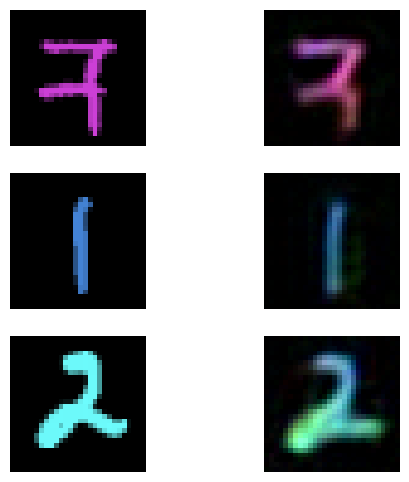

 50%|█████     | 15/30 [02:55<02:54, 11.64s/it]

epoch15 : loss=92.68522644042969
----------------------------------------


 53%|█████▎    | 16/30 [03:07<02:42, 11.60s/it]

epoch16 : loss=92.09973907470703
----------------------------------------


 57%|█████▋    | 17/30 [03:18<02:30, 11.58s/it]

epoch17 : loss=91.56916809082031
----------------------------------------


 60%|██████    | 18/30 [03:30<02:18, 11.56s/it]

epoch18 : loss=91.02030944824219
----------------------------------------


 63%|██████▎   | 19/30 [03:41<02:06, 11.54s/it]

epoch19 : loss=90.46045684814453
----------------------------------------


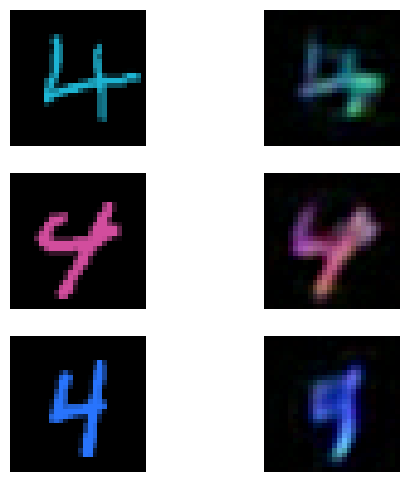

 67%|██████▋   | 20/30 [03:53<01:56, 11.61s/it]

epoch20 : loss=89.71583557128906
----------------------------------------


 70%|███████   | 21/30 [04:05<01:44, 11.57s/it]

epoch21 : loss=88.85906982421875
----------------------------------------


 73%|███████▎  | 22/30 [04:16<01:32, 11.55s/it]

epoch22 : loss=88.4980697631836
----------------------------------------


 77%|███████▋  | 23/30 [04:28<01:20, 11.53s/it]

epoch23 : loss=88.25234985351562
----------------------------------------


 80%|████████  | 24/30 [04:39<01:09, 11.52s/it]

epoch24 : loss=87.88031768798828
----------------------------------------


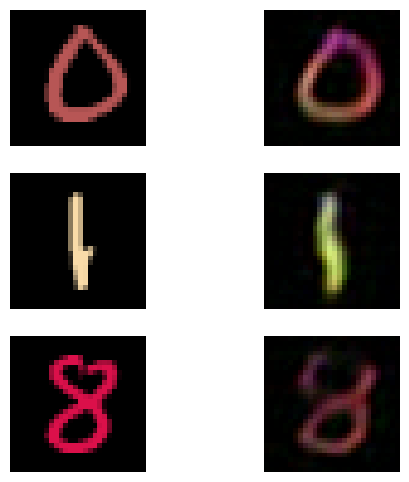

 83%|████████▎ | 25/30 [04:51<00:57, 11.59s/it]

epoch25 : loss=87.42582702636719
----------------------------------------


 87%|████████▋ | 26/30 [05:02<00:46, 11.57s/it]

epoch26 : loss=86.8431167602539
----------------------------------------


 90%|█████████ | 27/30 [05:14<00:34, 11.54s/it]

epoch27 : loss=86.61277770996094
----------------------------------------


 93%|█████████▎| 28/30 [05:25<00:23, 11.53s/it]

epoch28 : loss=86.82098388671875
----------------------------------------


 97%|█████████▋| 29/30 [05:37<00:11, 11.54s/it]

epoch29 : loss=86.95964050292969
----------------------------------------


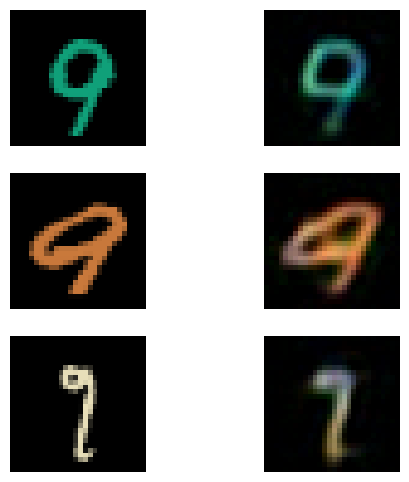

100%|██████████| 30/30 [05:49<00:00, 11.64s/it]

epoch30 : loss=86.87902069091797
----------------------------------------


In [ ]:
vq_vae_model2 = VQ_VAE(3, 200, 3, 10).to(device)
optimizer = optim.Adam(vq_vae_model2.parameters(), lr=1e-5)
vq_vae_model2 = train_model_2(vq_vae_model2, train_loader2, optimizer, num_epochs=30)

  3%|▎         | 1/30 [00:11<05:47, 12.00s/it]

epoch1 : loss=149.3820037841797
----------------------------------------


  7%|▋         | 2/30 [00:23<05:32, 11.87s/it]

epoch2 : loss=195.36300659179688
----------------------------------------


 10%|█         | 3/30 [00:35<05:18, 11.80s/it]

epoch3 : loss=209.4987335205078
----------------------------------------


 13%|█▎        | 4/30 [00:47<05:05, 11.77s/it]

epoch4 : loss=212.9476776123047
----------------------------------------


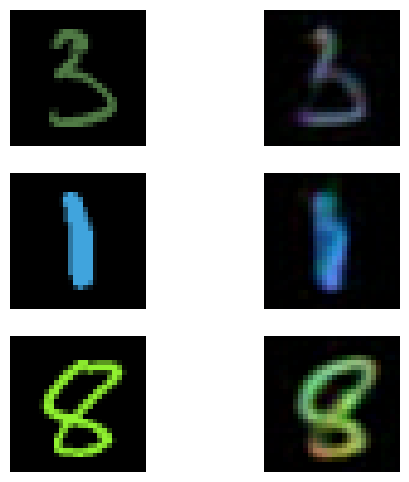

 17%|█▋        | 5/30 [00:59<04:56, 11.85s/it]

epoch5 : loss=217.9535675048828
----------------------------------------


 20%|██        | 6/30 [01:10<04:43, 11.81s/it]

epoch6 : loss=225.8123016357422
----------------------------------------


 23%|██▎       | 7/30 [01:22<04:30, 11.76s/it]

epoch7 : loss=231.13011169433594
----------------------------------------


 27%|██▋       | 8/30 [01:34<04:18, 11.74s/it]

epoch8 : loss=234.21690368652344
----------------------------------------


 30%|███       | 9/30 [01:45<04:06, 11.72s/it]

epoch9 : loss=237.31231689453125
----------------------------------------


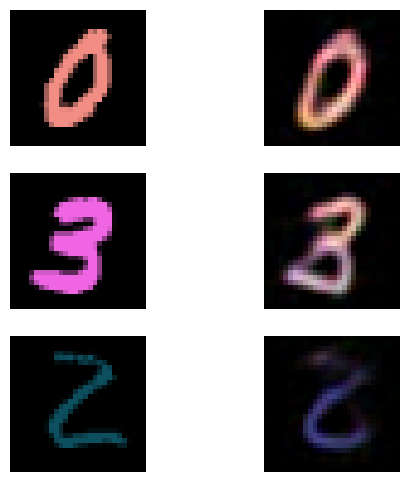

 33%|███▎      | 10/30 [01:57<03:55, 11.78s/it]

epoch10 : loss=241.85238647460938
----------------------------------------


 37%|███▋      | 11/30 [02:09<03:43, 11.74s/it]

epoch11 : loss=245.85006713867188
----------------------------------------


 40%|████      | 12/30 [02:21<03:30, 11.72s/it]

epoch12 : loss=250.59365844726562
----------------------------------------


 43%|████▎     | 13/30 [02:32<03:18, 11.70s/it]

epoch13 : loss=256.09820556640625
----------------------------------------


 47%|████▋     | 14/30 [02:44<03:06, 11.69s/it]

epoch14 : loss=259.3385314941406
----------------------------------------


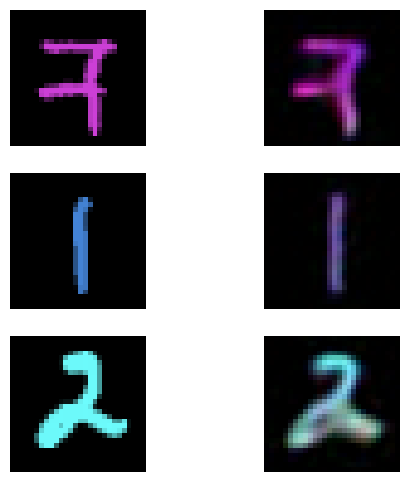

 50%|█████     | 15/30 [02:56<02:56, 11.75s/it]

epoch15 : loss=260.8567199707031
----------------------------------------


 53%|█████▎    | 16/30 [03:08<02:44, 11.74s/it]

epoch16 : loss=267.0257568359375
----------------------------------------


 57%|█████▋    | 17/30 [03:19<02:32, 11.72s/it]

epoch17 : loss=268.72430419921875
----------------------------------------


 60%|██████    | 18/30 [03:31<02:20, 11.69s/it]

epoch18 : loss=272.30810546875
----------------------------------------


 63%|██████▎   | 19/30 [03:43<02:08, 11.67s/it]

epoch19 : loss=274.8695068359375
----------------------------------------


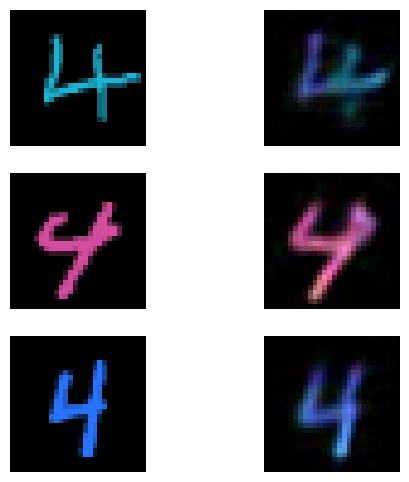

 67%|██████▋   | 20/30 [03:54<01:57, 11.73s/it]

epoch20 : loss=277.8279724121094
----------------------------------------


 70%|███████   | 21/30 [04:06<01:45, 11.70s/it]

epoch21 : loss=282.17822265625
----------------------------------------


 73%|███████▎  | 22/30 [04:18<01:33, 11.68s/it]

epoch22 : loss=282.42974853515625
----------------------------------------


 77%|███████▋  | 23/30 [04:29<01:21, 11.65s/it]

epoch23 : loss=283.1468505859375
----------------------------------------


 80%|████████  | 24/30 [04:41<01:09, 11.66s/it]

epoch24 : loss=285.4891662597656
----------------------------------------


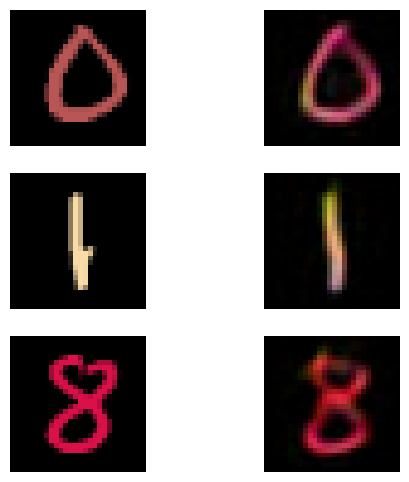

 83%|████████▎ | 25/30 [04:53<00:58, 11.72s/it]

epoch25 : loss=287.00897216796875
----------------------------------------


 87%|████████▋ | 26/30 [05:05<00:46, 11.72s/it]

epoch26 : loss=290.5765075683594
----------------------------------------


 90%|█████████ | 27/30 [05:16<00:35, 11.71s/it]

epoch27 : loss=293.8337097167969
----------------------------------------


 93%|█████████▎| 28/30 [05:28<00:23, 11.70s/it]

epoch28 : loss=297.3525390625
----------------------------------------


 97%|█████████▋| 29/30 [05:40<00:11, 11.69s/it]

epoch29 : loss=300.48052978515625
----------------------------------------


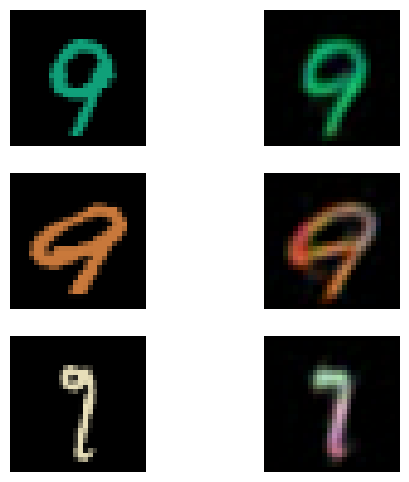

100%|██████████| 30/30 [05:51<00:00, 11.73s/it]

epoch30 : loss=303.0153503417969
----------------------------------------


In [ ]:
vq_vae_model2 = VQ_VAE(3, 200, 3, 50).to(device)
optimizer = optim.Adam(vq_vae_model2.parameters(), lr=0.0001)
vq_vae_model2 = train_model_2(vq_vae_model2, train_loader2, optimizer, num_epochs=30)

**ثابت نگه داشتن تعداد بردار ها و زیاد کردن ابعاد بردارها عملکرد مدل را کاهش می دهد**